In [1]:
#basic imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import glob

## Reading in the flight files

In [ ]:
# testing code using one month's data
#flights = pd.read_csv('data/2021_07_OTMC_OTP.csv')

In [ ]:
# lists all flight data files (2021-07 to 2024-12) to be reviewed and combined
file_list = sorted(glob.glob('data/*_OTMC_OTP.csv')) 

# check that all files have the same column names
columns_set = []
for file in file_list:
    df = pd.read_csv(file, nrows=0)  
    columns_set.append(set(df.columns))

all_same_columns = all(columns == columns_set[0] for columns in columns_set)
print("All files have the same columns:", all_same_columns)

# if all columns match, combine the files into a single DataFrame
if all_same_columns:
    flights_list = [pd.read_csv(f) for f in file_list]
    flights = pd.concat(flights_list, ignore_index=True)
    print("Combined DataFrame shape:", flights.shape)
else:
    print("Warning: Not all files have the same columns. Check differences before combining.")

## Data cleaning to get only diverted flights
See how flight diversion was determined and soft data cleaning

In [ ]:
# filter diverted flights only
# must have a diversion 1 airport that is different from the original destination
diverted_flights = flights[
    (
        flights['Div1Airport'].notna() & 
        (flights['Div1Airport'] != flights['Dest'])
    )
].copy()

#drop columns that do not have any data
empty_columns = diverted_flights.columns[diverted_flights.isna().all()]
diverted_flights = diverted_flights.dropna(axis=1, how='all')

# drop rows marked as duplicates
diverted_flights = diverted_flights.drop(diverted_flights[diverted_flights['Duplicate'] == 'Y'].index)


In [ ]:
# save diverted flights to a new CSV because this is the main data we will be working with and the original files were huge 
diverted_flights.to_csv('diverted_flights.csv', index=False)

## Diversion Data Calculations

If you are happy with how the data was cleaned, START RUNNING HERE

In [2]:
#if you are running this and are happy with the diverted_flights dataframe, just read in the saved CSV

diverted_flights = pd.read_csv('diverted_flights.csv')

/var/folders/vm/wvnpqlxd6fb74wjs_4f9kwd00000gn/T/ipykernel_98941/397122467.py:3: DtypeWarning: Columns (11,13,94,101) have mixed types. Specify dtype option on import or set low_memory=False.
  diverted_flights = pd.read_csv('diverted_flights.csv')


In [3]:
# flight date is original date of flight, not calculating for diversion
# calculate actual departure date and time

# convert to timedatetime for time calculations
diverted_flights['FlightDate'] = pd.to_datetime(diverted_flights['FlightDate'], errors='coerce')

#drop missing DepTime (cancelled flight) and fill DepDelay for calculations
diverted_flights['DepTime'] = diverted_flights['DepTime'].dropna()
diverted_flights['DepDelay'] = diverted_flights['DepDelay'].fillna(0)

# calculate actual departure date
diverted_flights['ActualDep'] = (
    diverted_flights['FlightDate'] +
    pd.to_timedelta(diverted_flights['DepTime'] // 100, unit='h') +
    pd.to_timedelta(diverted_flights['DepTime'] % 100, unit='m') +
    pd.to_timedelta(diverted_flights['DepDelay'], unit='m')
)

diverted_flights['ActualDepDate'] = diverted_flights['ActualDep'].dt.date
diverted_flights['ActualDepTime'] = diverted_flights['ActualDep'].dt.time


In [4]:
# just checking ActualDepTime and DepTime columns
time_check = diverted_flights[['DepTime', 'ActualDepTime']]

# the times are relatively similar, but enough to matter for date changes
# we will use ActualDepDate and ActualDepTime for further analysis for data completeness

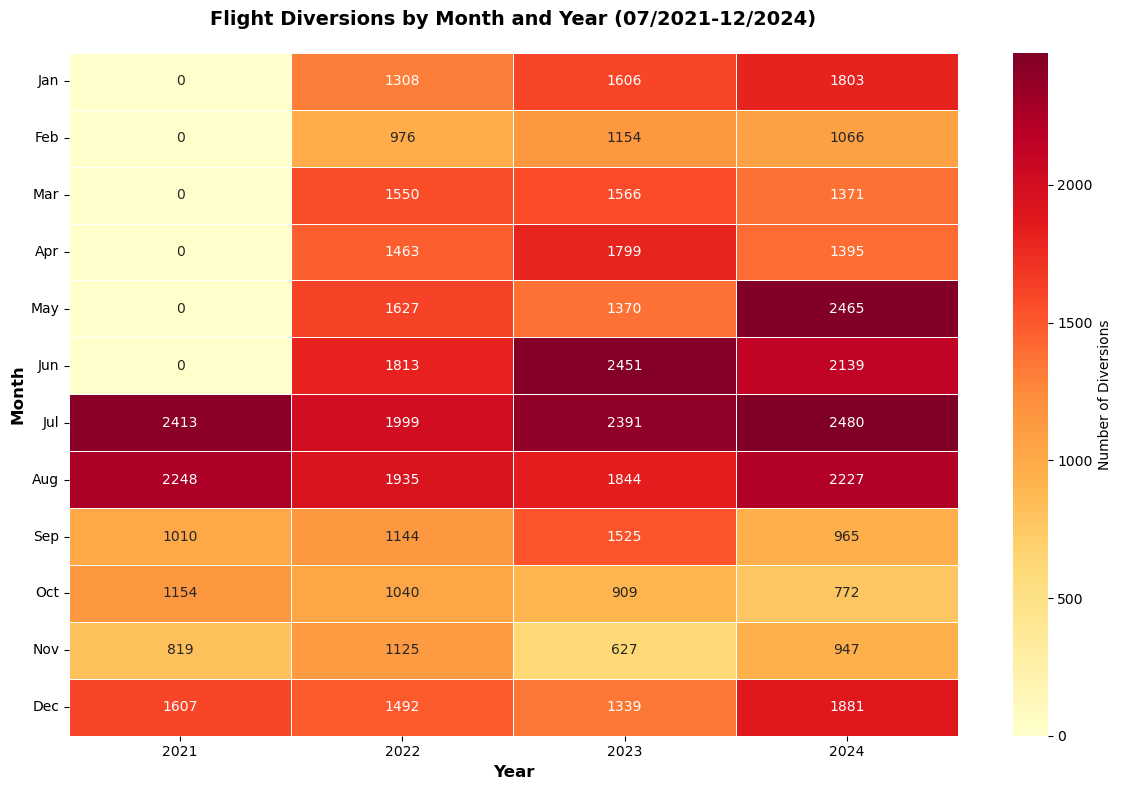

In [5]:
# extract year and month in datetime for analysis
diverted_flights['year'] = pd.to_datetime(diverted_flights['ActualDep']).dt.year
diverted_flights['month'] = pd.to_datetime(diverted_flights['ActualDep']).dt.month

# because this data is showing true flight times instead of scheduled, limit to 2024 only
diverted_flights = diverted_flights[diverted_flights['year'] <= 2024]

# heatmap of total diversions by month and year
month_year = diverted_flights.pivot_table(
    values='FlightDate',
    index='month',
    columns='year',
    aggfunc='count',
    fill_value=0
)

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    month_year,
    cmap='YlOrRd',
    annot=True,  # Show numbers in cells
    fmt='g',  # Format as integers
    ax=ax,
    cbar_kws={'label': 'Number of Diversions'},
    linewidths=0.5,
    linecolor='white'
)

# labeling for clarity
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
existing_months = month_year.index.tolist()
existing_labels = [month_names[int(m)-1] for m in existing_months]
ax.set_yticklabels(existing_labels, rotation=0)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Month', fontsize=12, fontweight='bold')
ax.set_title('Flight Diversions by Month and Year (07/2021-12/2024)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


### Did the diverted flight reach their destination?

In [ ]:
# Check if flight eventually reached destination through Div2Airport or Div3Airport
diverted_flights['reached_dest'] = (
    (diverted_flights['Div2Airport'] == diverted_flights['Dest']) | 
    (diverted_flights['Div3Airport'] == diverted_flights['Dest'])
)

# Create two separate datasets
reached_dest = diverted_flights[diverted_flights['reached_dest'] == True].copy()
not_reached_dest = diverted_flights[diverted_flights['reached_dest'] == False].copy()


In [ ]:
#testing because the reached_dest is really low 
manual_check = diverted_flights[['Origin', 'Dest', 'Div1Airport', 'Div2Airport', 'Div3Airport', 'DivReachedDest']].copy()

# Show flights that have Div2 or Div3 data
has_multiple_divs = manual_check[(manual_check['Div2Airport'].notna()) | (manual_check['Div3Airport'].notna())]


In [ ]:
reached_dest_column = diverted_flights[diverted_flights['DivReachedDest'] == 1].copy()
not_reached_dest_column = diverted_flights[diverted_flights['DivReachedDest'] != 1].copy()
# hmm... DivReachedDest does not show the same results as our calculated reached_dest column 
# NEEDS TO BE INVESTIGATED FURTHER

## Reading in the location data

In [6]:
airports = pd.read_csv('data/Airport_Loc.csv')

### Cleaning location data to only save the airport information that we need for diverted flights
They have non-US airport data that we don't need/use

In [7]:
# Get all unique airports used in diverted flights dataset
unique_airports = set()
unique_airports.update(diverted_flights['Origin'].unique())
unique_airports.update(diverted_flights['Dest'].unique())
unique_airports.update(diverted_flights['Div1Airport'].dropna().unique())

# Add Div2 and Div3 if they have data
if diverted_flights['Div2Airport'].notna().sum() > 0:
    unique_airports.update(diverted_flights['Div2Airport'].dropna().unique())
if diverted_flights['Div3Airport'].notna().sum() > 0:
    unique_airports.update(diverted_flights['Div3Airport'].dropna().unique())

# Filter airport coordinates to only airports we need
airports_clean = airports[airports['AIRPORT'].isin(unique_airports)].copy()

In [8]:
airports_clean.columns


Index(['AIRPORT_SEQ_ID', 'AIRPORT_ID', 'AIRPORT', 'DISPLAY_AIRPORT_NAME',
       'DISPLAY_AIRPORT_CITY_NAME_FULL', 'AIRPORT_WAC', 'AIRPORT_COUNTRY_NAME',
       'AIRPORT_COUNTRY_CODE_ISO', 'AIRPORT_STATE_NAME', 'AIRPORT_STATE_CODE',
       'AIRPORT_STATE_FIPS', 'CITY_MARKET_ID', 'DISPLAY_CITY_MARKET_NAME_FULL',
       'CITY_MARKET_WAC', 'LAT_DEGREES', 'LAT_HEMISPHERE', 'LAT_MINUTES',
       'LAT_SECONDS', 'LATITUDE', 'LON_DEGREES', 'LON_HEMISPHERE',
       'LON_MINUTES', 'LON_SECONDS', 'LONGITUDE', 'UTC_LOCAL_TIME_VARIATION',
       'AIRPORT_START_DATE', 'AIRPORT_THRU_DATE', 'AIRPORT_IS_CLOSED',
       'AIRPORT_IS_LATEST', 'Unnamed: 29'],
      dtype='object')

In [9]:
#drop all duplicate airport codes
airports_clean = airports_clean.drop_duplicates(subset=['AIRPORT'])


In [10]:
# check that all unique airports are accounted for and there is no missing location data
missing_airports = unique_airports - set(airports_clean['AIRPORT'].unique())
if len(missing_airports) > 0:
    print(f"\nMissing airports: {sorted(missing_airports)}")



Missing airports: ['BNH']


In [11]:
# i am manually going to input this airport data since there is only one missing airport (from the FAA website)
# BNH is a permanently closed airport in Boston - Boston Harbor Seaplane Base

BNH_airport = pd.DataFrame({
    'AIRPORT': ['BNH'],
    'LONGITUDE': [-71.0258333],
    'LATITUDE': [42.3525000]
})

# Add to airports_used dataset
airports_clean = pd.concat([airports_clean, BNH_airport], ignore_index=True)


In [12]:
#check to make sure that it added

if 'BNH' in airports_clean['AIRPORT'].values:
    print("BNH airport data successfully added.")
else: 
    print("BNH airport data NOT found.")

BNH airport data successfully added.


## Departure/Origin Airport Analysis

In [ ]:
#there are often diversion clusters over the span of a few days

#Define departure cluster, if time gap between diversions is more than 12 hours, start a new cluster
def origin_cluster(group, max_gap_hours=12):
    group = group.sort_values('ActualDep')
    group['time_since_last'] = group['ActualDep'].diff().dt.total_seconds() / 3600  # hours
    group['new_cluster'] = (group['time_since_last'] > max_gap_hours).fillna(True)
    group['cluster_id'] = group['new_cluster'].cumsum()
    return group


In [ ]:
# due to local time zones, we are not able to look purely at times and dates, each airport needs to be looked at individually. 

diverted_by_origin = diverted_flights.copy()  
diverted_by_origin = diverted_by_origin.groupby('Origin', group_keys=False).apply(origin_cluster)

# cluster summary by airport
cluster_summary_by_origin = diverted_by_origin.groupby(['Origin', 'cluster_id']).agg({
    'ActualDep': ['min', 'max', 'count']
}).reset_index()
cluster_summary_by_origin.columns = ['Origin', 'cluster_id', 'cluster_start_origin', 'cluster_end_origin', 'num_diversions_origin']

# get biggest clusters by number of diversions
biggest_origin_clusters = cluster_summary_by_origin.nlargest(20, 'num_diversions_origin')
biggest_origin_clusters


## Arrival/Destination Airport Analysis

### Original Arrival Time Airport Analysis

In [ ]:
# Analyzing when destination airports had issues causing diversions... using the CRS arrival time to potentially weather or airport operations related

#Define arrival cluster, if time gap between diversions is more than 12 hours, start a new cluster
def dest_cluster(group, max_gap_hours=12):
    group = group.sort_values('ScheduledArrival')  # Sort by datetime, not integer
    group['time_since_last'] = group['ScheduledArrival'].diff().dt.total_seconds() / 3600  # hours
    group['new_cluster'] = (group['time_since_last'] > max_gap_hours).fillna(True)
    group['cluster_id'] = group['new_cluster'].cumsum()
    return group

In [ ]:
# calculate scheduled arrival in datetime 
diverted_flights['ScheduledArrival'] = (
    diverted_flights['FlightDate'] +
    pd.to_timedelta(diverted_flights['CRSArrTime'] // 100, unit='h') +
    pd.to_timedelta(diverted_flights['CRSArrTime'] % 100, unit='m')
)
# group by destination airport
diverted_by_dest = diverted_flights.copy()  
diverted_by_dest = diverted_by_dest.groupby('Dest', group_keys=False).apply(dest_cluster)

# Cluster by DESTINATION airport based on when they were supposed to arrive
cluster_summary_by_dest = diverted_by_dest.groupby(['Dest', 'cluster_id']).agg({
    'ScheduledArrival': ['min', 'max', 'count'],
    'Origin': lambda x: x.nunique(),  # How many different origins affected
    'Div1Airport': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]  # Where did they divert to?
}).reset_index()

cluster_summary_by_dest.columns = ['Dest', 'cluster_id', 'cluster_start_dest', 'cluster_end_dest', 'num_diversions_dest', 'num_origins_affected', 'primary_diversion_airport']

# Get biggest clusters by number of diversions
biggest_dest_clusters = cluster_summary_by_dest.nlargest(20, 'num_diversions_dest')
biggest_dest_clusters

### Actual Arrival Time Airport Analysis

In [13]:
# Analyzing when destination airports had issues causing diversions... using the actual arrival time to see if delays in arrival times correlate with diversions
# this could mean that the decision to divert was made closer to arrival time rather than at departure (last minute weather changes, runway issues, etc.)

# Define arrival cluster based on estimated arrival, delay dependent, if time gap between diversions is more than 12 hours, start a new cluster
def dest_actual_cluster(group, max_gap_hours=12):
    group = group.sort_values('EstimatedActualArrival')
    group['time_since_last'] = group['EstimatedActualArrival'].diff().dt.total_seconds() / 3600  # hours
    group['new_cluster'] = (group['time_since_last'] > max_gap_hours).fillna(True)
    group['cluster_id'] = group['new_cluster'].cumsum()
    return group

In [14]:
# Calculate estimated actual arrival time using actual departure + expected flight duration
diverted_flights['CRSElapsedTime'] = diverted_flights['CRSElapsedTime'].fillna(0)

diverted_flights['EstimatedActualArrival'] = (
    diverted_flights['ActualDep'] +
    pd.to_timedelta(diverted_flights['CRSElapsedTime'], unit='m')
)

# Create separate dataframe for destination actual arrival analysis
diverted_by_dest_actual = diverted_flights.copy()

# Cluster by destination airport based on estimated actual arrival time
diverted_by_dest_actual = diverted_by_dest_actual.groupby('Dest', group_keys=False).apply(dest_actual_cluster)

# Cluster summary by DESTINATION airport using actual arrival
cluster_summary_by_dest_actual = diverted_by_dest_actual.groupby(['Dest', 'cluster_id']).agg({
    'EstimatedActualArrival': ['min', 'max', 'count'],
    'Origin': lambda x: x.nunique(),  # How many different origins affected
    'Div1Airport': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]  # Where did they divert to?
}).reset_index()

cluster_summary_by_dest_actual.columns = ['Dest', 'cluster_id', 'cluster_start_dest_actual', 'cluster_end_dest_actual', 'num_diversions_dest_actual', 'num_origins_affected', 'primary_diversion_airport']

# Get biggest destination clusters by number of diversions
biggest_dest_actual_clusters = cluster_summary_by_dest_actual.nlargest(20, 'num_diversions_dest_actual')
biggest_dest_actual_clusters

/var/folders/vm/wvnpqlxd6fb74wjs_4f9kwd00000gn/T/ipykernel_98941/2964285410.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diverted_by_dest_actual = diverted_by_dest_actual.groupby('Dest', group_keys=False).apply(dest_actual_cluster)


Dest  cluster_id cluster_start_dest_actual cluster_end_dest_actual  \
22411  SAN         283       2024-12-18 16:39:00     2024-12-21 16:55:00   
7320   DFW         513       2024-11-04 12:28:00     2024-11-05 00:50:00   
18498  ORD          36       2021-08-24 13:49:00     2021-08-26 04:25:00   
14494  LGA         106       2022-03-17 07:19:00     2022-03-18 09:02:00   
1320   ATL         245       2023-08-06 11:45:00     2023-08-07 20:09:00   
1142   ATL          67       2022-01-28 14:36:00     2022-01-29 07:29:00   
7340   DFW         533       2024-12-24 07:14:00     2024-12-24 22:59:00   
7239   DFW         432       2024-05-26 09:11:00     2024-05-29 01:19:00   
6979   DFW         172       2022-08-10 14:32:00     2022-08-10 21:58:00   
7338   DFW         531       2024-12-16 09:08:00     2024-12-16 21:13:00   
7242   DFW         435       2024-06-02 07:04:00     2024-06-03 03:06:00   
13884  LAX         239       2023-02-23 13:51:00     2023-02-26 02:12:00   
6807   DFW           0       2021-07-01 04:26:00     2021-07-02 15:11:00   
7014   DFW         207       2022-10-24 08:39:00     2022-10-25 00:39:00   
19005  ORD         543       2024-07-13 04:03:00     2024-07-16 10:43:00   
14758  LGA         370       2023-09-07 01:45:00     2023-09-10 13:36:00   
6526   DEN         268       2023-04-18 16:57:00     2023-04-19 21:37:00   
6828   DFW          21       2021-08-01 06:22:00     2021-08-02 07:07:00   
6985   DFW         178       2022-08-21 12:21:00     2022-08-22 17:43:00   
6557   DEN         299       2023-06-21 09:26:00     2023-06-22 05:37:00   

       num_diversions_dest_actual  num_origins_affected  \
22411                         140                    43   
7320                          110                    71   
18498                         108                    72   
14494                         101                    44   
1320                           99                    62   
1142                           95                    69   
7340                           94                    72   
7239                           93                    69   
6979                           92                    74   
7338                           91                    76   
7242                           90                    73   
13884                          90                    39   
6807                           88                    65   
7014                           87                    70   
19005                          87                    45   
14758                          83                    33   
6526                           82                    58   
6828                           82                    66   
6985                           82                    62   
6557                           77                    51   

      primary_diversion_airport  
22411                       PHX  
7320                        IAH  
18498                       IND  
14494                       JFK  
1320                        BNA  
1142                        CAE  
7340                        IAH  
7239                        OKC  
6979                        TUL  
7338                        TUL  
7242                        OKC  
13884                       LAS  
6807                        AUS  
7014                        IAH  
19005                       IND  
14758                       PIT  
6526                        COS  
6828                        OKC  
6985                        OKC  
6557                        SLC

#### Local/Regional/Widespread Diversion Cluster Determination

In [15]:
# Analyzing what other airports experienced diversions during the top destination cluster events
# this helps identify if diversions were localized to one destination or part of a broader regional/system issue

# Get the top 5 destination clusters
top_5_dest_clusters = biggest_dest_actual_clusters.head(5)

print("TOP 5 DESTINATION CLUSTER EVENTS\n")
for idx, cluster in top_5_dest_clusters.iterrows():
    print(f"\nCluster {idx + 1}:")
    print(f"  Destination: {cluster['Dest']}")
    print(f"  Time period: {cluster['cluster_start_dest_actual']} to {cluster['cluster_end_dest_actual']}")
    print(f"  Diversions to this destination: {cluster['num_diversions_dest_actual']}")
    print(f"  Origins affected: {cluster['num_origins_affected']}")
    print(f"  Primary diversion airport: {cluster['primary_diversion_airport']}")




TOP 5 DESTINATION CLUSTER EVENTS


Cluster 22412:
  Destination: SAN
  Time period: 2024-12-18 16:39:00 to 2024-12-21 16:55:00
  Diversions to this destination: 140
  Origins affected: 43
  Primary diversion airport: PHX

Cluster 7321:
  Destination: DFW
  Time period: 2024-11-04 12:28:00 to 2024-11-05 00:50:00
  Diversions to this destination: 110
  Origins affected: 71
  Primary diversion airport: IAH

Cluster 18499:
  Destination: ORD
  Time period: 2021-08-24 13:49:00 to 2021-08-26 04:25:00
  Diversions to this destination: 108
  Origins affected: 72
  Primary diversion airport: IND

Cluster 14495:
  Destination: LGA
  Time period: 2022-03-17 07:19:00 to 2022-03-18 09:02:00
  Diversions to this destination: 101
  Origins affected: 44
  Primary diversion airport: JFK

Cluster 1321:
  Destination: ATL
  Time period: 2023-08-06 11:45:00 to 2023-08-07 20:09:00
  Diversions to this destination: 99
  Origins affected: 62
  Primary diversion airport: BNA


In [16]:
# For each top cluster, find ALL diversions happening during that time window
for idx, cluster in top_5_dest_clusters.iterrows():
    dest_airport = cluster['Dest']
    cluster_start = cluster['cluster_start_dest_actual']
    cluster_end = cluster['cluster_end_dest_actual']
    
    print(f"\n{'='*80}")
    print(f"CLUSTER EVENT: {dest_airport} ({cluster_start} to {cluster_end})")
    print(f"{'='*80}\n")
    
    # all flights with estimated actual arrivals during this time window (local)
    all_diversions_during_cluster = diverted_flights[
        (diverted_flights['EstimatedActualArrival'] >= cluster_start) &
        (diverted_flights['EstimatedActualArrival'] <= cluster_end)
    ].copy()
    
    print(f"Total diversions system-wide during this period: {len(all_diversions_during_cluster)}")
    print(f"Diversions to {dest_airport}: {len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] == dest_airport])}")
    print(f"Diversions to OTHER destinations: {len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] != dest_airport])}\n")
    
    # Break down by destination airport
    print("Diversions by intended destination airport:")
    dest_breakdown = all_diversions_during_cluster.groupby('Dest').agg({
        'Origin': 'count',
        'Div1Airport': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Various'
    }).rename(columns={'Origin': 'num_diversions', 'Div1Airport': 'common_diversion'})
    dest_breakdown = dest_breakdown.sort_values('num_diversions', ascending=False)
    print(dest_breakdown.head(10))
    
    # Break down by diversion airport (where they actually landed)
    print(f"\nDiversion airports used during this period:")
    div_airport_breakdown = all_diversions_during_cluster.groupby('Div1Airport').size().sort_values(ascending=False)
    print(div_airport_breakdown.head(10))
    
    # Break down by origin airport
    print(f"\nOrigin airports affected:")
    origin_breakdown = all_diversions_during_cluster.groupby('Origin').size().sort_values(ascending=False)
    print(origin_breakdown.head(10))
    
    # Geographic spread analysis
    unique_dests = all_diversions_during_cluster['Dest'].nunique()
    unique_origins = all_diversions_during_cluster['Origin'].nunique()
    unique_div_airports = all_diversions_during_cluster['Div1Airport'].nunique()
    
    print(f"\nGeographic spread:")
    print(f"  Unique destination airports affected: {unique_dests}")
    print(f"  Unique origin airports: {unique_origins}")
    print(f"  Unique diversion airports used: {unique_div_airports}")
    
    # Calculate if this was a localized or widespread event
    pct_to_main_dest = (len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] == dest_airport]) / 
                        len(all_diversions_during_cluster) * 100)
    
    print(f"\nEvent characterization:")
    if pct_to_main_dest > 80:
        print(f"  LOCALIZED EVENT - {pct_to_main_dest:.1f}% of diversions were to {dest_airport}")
    elif pct_to_main_dest > 50:
        print(f"  REGIONAL EVENT - {pct_to_main_dest:.1f}% of diversions were to {dest_airport}, but other airports also affected")
    else:
        print(f"  WIDESPREAD EVENT - Only {pct_to_main_dest:.1f}% of diversions were to {dest_airport}, many other airports affected")


CLUSTER EVENT: SAN (2024-12-18 16:39:00 to 2024-12-21 16:55:00)

Total diversions system-wide during this period: 290
Diversions to SAN: 140
Diversions to OTHER destinations: 150

Diversions by intended destination airport:
      num_diversions common_diversion
Dest                                 
SAN              140              PHX
SNA               30              ONT
EYW               20              MIA
BOS               17              BDL
LAX                7              ONT
LGB                7              ONT
MDW                4              IND
SJC                3              MRY
LAS                2              MSY
HRL                2              BRO

Diversion airports used during this period:
Div1Airport
ONT    48
PHX    33
LAX    32
LAS    31
PSP    16
MIA    13
SFO     9
SJC     7
BDL     7
PHL     5
dtype: int64

Origin airports affected:
Origin
ATL    15
SFO    15
DEN    15
DFW    13
PHX    12
PHL    11
LAS    11
CLT    10
SEA    10
LAX     8
dtype: int64

G

## Airline/Hub Airport Patterns

In [17]:
# printing the unique airlines
unique_airlines = diverted_flights['Marketing_Airline_Network'].unique()
unique_airlines

array(['UA', 'WN', 'AA', 'DL', 'AS', 'B6', 'F9', 'G4', 'HA', 'NK'],
      dtype=object)

In [18]:
# Analyzing carrier patterns in diversions - examining hub airport relationships and carrier-specific vulnerabilities
# carriers may have different diversion patterns based on their hub airports and operational preferences

# define major US carrier hubs based on airline operational designations. 
# I got these from a bunch of websites/google searches so I am not 100% sure on all of them
carrier_hubs = {
    'AA': ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA'],  # American
    'DL': ['ATL', 'BOS', 'DTW', 'LAX', 'MSP', 'JFK', 'LGA', 'SLC', 'SEA'],  # Delta
    'UA': ['ORD', 'DEN', 'IAH', 'LAX', 'EWR', 'SFO', 'IAD'],  # United
    'WN': ['ATL', 'BWI', 'MDW', 'DAL', 'DEN', 'LAS'],  # Southwest (point-to-point but major bases)
    'AS': ['ANC', 'SEA', 'PDX', 'LAX', 'SFO', 'SAN', 'SJC'],  # Alaska
    'B6': ['JFK', 'BOS', 'FLL', 'MCO', 'LAX'],  # JetBlue
    'F9': ['DEN', 'ATL', 'ORD', 'LAS', 'MCO', 'PHL'],  # Frontier
    'G4': ['LAS', 'SFB', 'PIE'],  # Allegiant
    'HA': ['HNL', 'OGG'],  # Hawaiian
    'NK': ['FLL', 'MCO', 'DTW', 'LAS', 'ORD', 'DFW'],  # Spirit
}

In [19]:
# hub indicator initiation - if origin, dest, or diversion airport is a hub for the operating carrier
diverted_flights['origin_is_carrier_hub'] = False #might not mean anything for origin airport being a hub
diverted_flights['dest_is_carrier_hub'] = False # this might also not mean anything for destination airport being a hub
diverted_flights['div_is_carrier_hub'] = False


for carrier, hubs in carrier_hubs.items():
    carrier_mask = diverted_flights['Marketing_Airline_Network'] == carrier
    diverted_flights.loc[carrier_mask, 'origin_is_carrier_hub'] = diverted_flights.loc[carrier_mask, 'Origin'].isin(hubs)
    diverted_flights.loc[carrier_mask, 'dest_is_carrier_hub'] = diverted_flights.loc[carrier_mask, 'Dest'].isin(hubs)
    diverted_flights.loc[carrier_mask, 'div_is_carrier_hub'] = diverted_flights.loc[carrier_mask, 'Div1Airport'].isin(hubs)


In [20]:
# Overall carrier diversion rates
print("Diversions by carrier:")
carrier_diversions = diverted_flights.groupby('Marketing_Airline_Network').size().sort_values(ascending=False)
print(carrier_diversions)

# Hub involvement analysis
print("\nDiversions by Hubs:\n")
print("Diversions originating from carrier's own hubs:")
hub_origin_pct = (diverted_flights['origin_is_carrier_hub'].sum() / len(diverted_flights) * 100)
print(f"  {diverted_flights['origin_is_carrier_hub'].sum():,} diversions ({hub_origin_pct:.1f}%)")

print("\nDiversions destined for carrier's own hubs:")
hub_dest_pct = (diverted_flights['dest_is_carrier_hub'].sum() / len(diverted_flights) * 100)
print(f"  {diverted_flights['dest_is_carrier_hub'].sum():,} diversions ({hub_dest_pct:.1f}%)")

print("\nDiversions landing at carrier's own hubs:")
hub_div_pct = (diverted_flights['div_is_carrier_hub'].sum() / len(diverted_flights) * 100)
print(f"  {diverted_flights['div_is_carrier_hub'].sum():,} diversions ({hub_div_pct:.1f}%)")


Diversions by carrier:
Marketing_Airline_Network
AA    18004
UA    13921
DL    10886
WN    10285
AS     3922
B6     3653
NK     1659
G4     1186
F9     1012
HA      287
dtype: int64

Diversions by Hubs:

Diversions originating from carrier's own hubs:
  32,862 diversions (50.7%)

Diversions destined for carrier's own hubs:
  30,573 diversions (47.2%)

Diversions landing at carrier's own hubs:
  16,446 diversions (25.4%)


In [21]:
# hub analysis by carrier
for carrier in carrier_diversions.index:
    carrier_data = diverted_flights[diverted_flights['Marketing_Airline_Network'] == carrier]
    
    if len(carrier_data) < 10:  # Skip carriers with very few diversions
        continue
    
    print(f"\n{carrier} ({len(carrier_data):,} diversions):")
    
    # Hub percentages
    origin_hub_pct = (carrier_data['origin_is_carrier_hub'].sum() / len(carrier_data) * 100)
    dest_hub_pct = (carrier_data['dest_is_carrier_hub'].sum() / len(carrier_data) * 100)
    div_hub_pct = (carrier_data['div_is_carrier_hub'].sum() / len(carrier_data) * 100)
    
    print(f"  Origin at own hub: {origin_hub_pct:.1f}%")
    print(f"  Destination at own hub: {dest_hub_pct:.1f}%")
    print(f"  Diverted to own hub: {div_hub_pct:.1f}%")
    
    # Top diversion airports for this carrier
    top_div_airports = carrier_data['Div1Airport'].value_counts().head(5)
    print(f"  Top diversion airports:")
    for airport, count in top_div_airports.items():
        is_hub = airport in carrier_hubs.get(carrier, [])
        hub_marker = " (HUB)" if is_hub else ""
        print(f"    {airport}: {count}{hub_marker}")



AA (18,004 diversions):
  Origin at own hub: 54.6%
  Destination at own hub: 56.4%
  Diverted to own hub: 23.3%
  Top diversion airports:
    DFW: 984 (HUB)
    CLT: 892 (HUB)
    PHL: 610 (HUB)
    IAD: 569
    OKC: 509

UA (13,921 diversions):
  Origin at own hub: 54.3%
  Destination at own hub: 51.7%
  Diverted to own hub: 28.7%
  Top diversion airports:
    DEN: 1149 (HUB)
    COS: 737
    IAD: 719 (HUB)
    ORD: 663 (HUB)
    GJT: 578

DL (10,886 diversions):
  Origin at own hub: 60.4%
  Destination at own hub: 45.8%
  Diverted to own hub: 25.4%
  Top diversion airports:
    ATL: 636 (HUB)
    DTW: 583 (HUB)
    MSP: 434 (HUB)
    SLC: 385 (HUB)
    JFK: 301 (HUB)

WN (10,285 diversions):
  Origin at own hub: 33.3%
  Destination at own hub: 35.4%
  Diverted to own hub: 14.5%
  Top diversion airports:
    LAX: 465
    ONT: 351
    LAS: 336 (HUB)
    STL: 331
    AUS: 330

AS (3,922 diversions):
  Origin at own hub: 58.8%
  Destination at own hub: 38.0%
  Diverted to own hub: 44.7%

In [22]:
# Hub diversion usage by carrier
print("=== HUB AS DIVERSION AIRPORT USAGE ===\n")

for carrier, hubs in carrier_hubs.items():
    carrier_data = diverted_flights[diverted_flights['Marketing_Airline_Network'] == carrier]
    hub_div_landings = carrier_data[carrier_data['Div1Airport'].isin(hubs)]
    
    if len(hub_div_landings) > 0:
        print(f"\n{carrier}:")
        hub_breakdown = hub_div_landings.groupby('Div1Airport').size().sort_values(ascending=False)
        for hub, count in hub_breakdown.items():
            pct = (count / len(carrier_data) * 100)
            print(f"  {hub}: {count} diversions ({pct:.1f}% of carrier's total diversions)")

=== HUB AS DIVERSION AIRPORT USAGE ===


AA:
  DFW: 984 diversions (5.5% of carrier's total diversions)
  CLT: 892 diversions (5.0% of carrier's total diversions)
  PHL: 610 diversions (3.4% of carrier's total diversions)
  PHX: 495 diversions (2.7% of carrier's total diversions)
  ORD: 356 diversions (2.0% of carrier's total diversions)
  MIA: 316 diversions (1.8% of carrier's total diversions)
  LAX: 231 diversions (1.3% of carrier's total diversions)
  JFK: 191 diversions (1.1% of carrier's total diversions)
  DCA: 89 diversions (0.5% of carrier's total diversions)
  LGA: 26 diversions (0.1% of carrier's total diversions)

DL:
  ATL: 636 diversions (5.8% of carrier's total diversions)
  DTW: 583 diversions (5.4% of carrier's total diversions)
  MSP: 434 diversions (4.0% of carrier's total diversions)
  SLC: 385 diversions (3.5% of carrier's total diversions)
  JFK: 301 diversions (2.8% of carrier's total diversions)
  LAX: 180 diversions (1.7% of carrier's total diversions)
  SEA: 1

## Diversion Visualization

### Coordinate diversion function

In [23]:
#function to get lat/lon for an airport code - I will use this for visualizations  
def get_coords(airport_code, airports_df):
    """Get latitude and longitude for an airport code"""
    result = airports_df[airports_df['AIRPORT'] == airport_code]
    if len(result) > 0:
        return result.iloc[0]['LATITUDE'], result.iloc[0]['LONGITUDE']
    return None, None



In [24]:
# testing function
lat, lon = get_coords('SAN', airports_clean)
print(f"SAN: {lat}, {lon}")

SAN: 32.73277778, -117.18722222


### Cluster visualization

#### For diversions heading to the top cluster based on destination

In [29]:
# ============================================================
# SYSTEM-WIDE DIVERSIONS DURING TOP 3 CLUSTER PERIODS
# ============================================================

import plotly.graph_objects as go
import numpy as np

def create_bezier_curve(lat1, lon1, lat2, lon2, num_points=100):
    mid_lat = (lat1 + lat2) / 2
    mid_lon = (lon1 + lon2) / 2
    dx = lon2 - lon1
    dy = lat2 - lat1
    distance = np.sqrt(dx**2 + dy**2)
    
    if distance > 0:
        offset = distance * 0.2
        control_lat = mid_lat + offset * (dx / distance) * 0.15
        control_lon = mid_lon - offset * (dy / distance) * 0.15
    else:
        control_lat = mid_lat
        control_lon = mid_lon
    
    t = np.linspace(0, 1, num_points)
    lats = [(1-ti)**2 * lat1 + 2*(1-ti)*ti * control_lat + ti**2 * lat2 for ti in t]
    lons = [(1-ti)**2 * lon1 + 2*(1-ti)*ti * control_lon + ti**2 * lon2 for ti in t]
    return lats, lons

# Color setup - manually define distinct colors
airline_colors = {
    'American Airlines': '#E74C3C',      # Red
    'AA': '#E74C3C',
    'Delta Air Lines': '#3498DB',         # Blue
    'DL': '#3498DB',
    'United Airlines': '#2ECC71',         # Green
    'UA': '#2ECC71',
    'Southwest Airlines': '#F39C12',      # Orange
    'WN': '#F39C12',
    'Alaska Airlines': '#9B59B6',         # Purple
    'AS': '#9B59B6',
    'JetBlue Airways': '#1ABC9C',         # Teal
    'B6': '#1ABC9C',
    'Spirit Airlines': '#E67E22',         # Dark Orange
    'NK': '#E67E22',
    'Frontier Airlines': '#34495E',       # Dark Gray
    'F9': '#34495E',
    'Hawaiian Airlines': '#16A085',       # Dark Teal
    'HA': '#16A085',
    'Allegiant Air': '#C0392B',           # Dark Red
    'G4': '#C0392B',
}

# For any airline not in the dictionary, assign a default color
def get_airline_color(airline):
    if airline in airline_colors:
        return airline_colors[airline]
    else:
        return '#808080'  # Gray for unknown airlines

# Process top 3 clusters
for cluster_num in range(3):
    cluster = biggest_dest_actual_clusters.iloc[cluster_num]
    
    dest_airport = cluster['Dest']
    cluster_start = cluster['cluster_start_dest_actual']
    cluster_end = cluster['cluster_end_dest_actual']
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_num + 1} EVENT: {dest_airport} ({cluster_start} to {cluster_end})")
    print(f"{'='*80}\n")
    
    # ALL flights with estimated actual arrivals during this time window
    all_diversions_during_cluster = diverted_flights[
        (diverted_flights['EstimatedActualArrival'] >= cluster_start) &
        (diverted_flights['EstimatedActualArrival'] <= cluster_end)
    ].copy()
    
    print(f"Total diversions system-wide during this period: {len(all_diversions_during_cluster)}")
    print(f"Diversions to {dest_airport}: {len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] == dest_airport])}")
    print(f"Diversions to OTHER destinations: {len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] != dest_airport])}\n")
    
    # Break down by destination airport
    print("Diversions by intended destination airport:")
    dest_breakdown = all_diversions_during_cluster.groupby('Dest').agg({
        'Origin': 'count',
        'Div1Airport': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Various'
    }).rename(columns={'Origin': 'num_diversions', 'Div1Airport': 'common_diversion'})
    dest_breakdown = dest_breakdown.sort_values('num_diversions', ascending=False)
    print(dest_breakdown.head(10))
    
    # Break down by diversion airport
    print(f"\nDiversion airports used during this period:")
    div_airport_breakdown = all_diversions_during_cluster.groupby('Div1Airport').size().sort_values(ascending=False)
    print(div_airport_breakdown.head(10))
    
    # Break down by origin airport
    print(f"\nOrigin airports affected:")
    origin_breakdown = all_diversions_during_cluster.groupby('Origin').size().sort_values(ascending=False)
    print(origin_breakdown.head(10))
    
    # Geographic spread analysis
    unique_dests = all_diversions_during_cluster['Dest'].nunique()
    unique_origins = all_diversions_during_cluster['Origin'].nunique()
    unique_div_airports = all_diversions_during_cluster['Div1Airport'].nunique()
    
    print(f"\nGeographic spread:")
    print(f"  Unique destination airports affected: {unique_dests}")
    print(f"  Unique origin airports: {unique_origins}")
    print(f"  Unique diversion airports used: {unique_div_airports}")
    
    # Calculate event characterization
    pct_to_main_dest = (len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] == dest_airport]) / 
                        len(all_diversions_during_cluster) * 100)
    
    print(f"\nEvent characterization:")
    if pct_to_main_dest > 80:
        print(f"  LOCALIZED EVENT - {pct_to_main_dest:.1f}% of diversions were to {dest_airport}")
    elif pct_to_main_dest > 50:
        print(f"  REGIONAL EVENT - {pct_to_main_dest:.1f}% of diversions were to {dest_airport}, but other airports also affected")
    else:
        print(f"  WIDESPREAD EVENT - Only {pct_to_main_dest:.1f}% of diversions were to {dest_airport}, many other airports affected")
    
    # Add coordinates
    all_diversions_during_cluster['origin_lat'] = all_diversions_during_cluster['Origin'].apply(
        lambda x: get_coords(x, airports_clean)[0]
    )
    all_diversions_during_cluster['origin_lon'] = all_diversions_during_cluster['Origin'].apply(
        lambda x: get_coords(x, airports_clean)[1]
    )
    all_diversions_during_cluster['div_lat'] = all_diversions_during_cluster['Div1Airport'].apply(
        lambda x: get_coords(x, airports_clean)[0]
    )
    all_diversions_during_cluster['div_lon'] = all_diversions_during_cluster['Div1Airport'].apply(
        lambda x: get_coords(x, airports_clean)[1]
    )
    all_diversions_during_cluster['dest_lat'] = all_diversions_during_cluster['Dest'].apply(
        lambda x: get_coords(x, airports_clean)[0]
    )
    all_diversions_during_cluster['dest_lon'] = all_diversions_during_cluster['Dest'].apply(
        lambda x: get_coords(x, airports_clean)[1]
    )
    
    # Remove missing coordinates
    all_diversions_during_cluster = all_diversions_during_cluster.dropna(subset=['origin_lat', 'div_lat', 'dest_lat'])
    
    print(f"\nFlights with complete coordinates: {len(all_diversions_during_cluster)}")
    
    # Create figure
    fig = go.Figure()
    
    # Add ALL flight paths
    for idx, row in all_diversions_during_cluster.iterrows():
        airline = row['Marketing_Airline_Network']
        origin = row['Origin']
        diversion = row['Div1Airport']
        dest = row['Dest']
        
        lats, lons = create_bezier_curve(
            row['origin_lat'], row['origin_lon'],
            row['div_lat'], row['div_lon']
        )
        
        fig.add_trace(go.Scattergeo(
            lon=lons,
            lat=lats,
            mode='lines',
            line=dict(width=2, color=get_airline_color(airline)),
            opacity=0.4,
            hoverinfo='text',
            hovertext=f"{origin} → {diversion}<br>Intended: {dest}<br>{airline}",
            showlegend=False,
            name=airline,
            legendgroup=airline
        ))
    
    # Add origin markers
    all_origins = all_diversions_during_cluster.drop_duplicates('Origin')[['Origin', 'origin_lat', 'origin_lon']].reset_index(drop=True)
    fig.add_trace(go.Scattergeo(
        lon=all_origins['origin_lon'],
        lat=all_origins['origin_lat'],
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8, line=dict(width=1, color='darkblue')),
        text=all_origins['Origin'],
        hovertemplate='<b>Origin: %{text}</b><extra></extra>',
        name='Flight Origins',
        showlegend=True
    ))
    
    # Add diversion markers
    all_diversions = all_diversions_during_cluster.drop_duplicates('Div1Airport')[['Div1Airport', 'div_lat', 'div_lon']].reset_index(drop=True)
    fig.add_trace(go.Scattergeo(
        lon=all_diversions['div_lon'],
        lat=all_diversions['div_lat'],
        mode='markers',
        marker=dict(size=8, color='red', symbol='star', opacity=0.8, line=dict(width=1, color='darkred')),
        text=all_diversions['Div1Airport'],
        hovertemplate='<b>Diversion: %{text}</b><extra></extra>',
        name='Diversion Airports',
        showlegend=True
    ))
    
    # Add intended destinations - main cluster in gold, others in light green
    all_dests = all_diversions_during_cluster.drop_duplicates('Dest')[['Dest', 'dest_lat', 'dest_lon']].reset_index(drop=True)
    
    main_dest_data = all_dests[all_dests['Dest'] == dest_airport]
    other_dest_data = all_dests[all_dests['Dest'] != dest_airport]
    
    if len(main_dest_data) > 0:
        fig.add_trace(go.Scattergeo(
            lon=main_dest_data['dest_lon'],
            lat=main_dest_data['dest_lat'],
            mode='markers+text',
            marker=dict(size=12, color='gold', symbol='diamond', opacity=0.95, line=dict(width=1.5, color='orange')),
            text=main_dest_data['Dest'],
            textposition='top center',
            hovertemplate='<b>%{text}</b><br>Main Cluster Destination<extra></extra>',
            name='Main Cluster Destination',
            showlegend=True
        ))
    
    if len(other_dest_data) > 0:
        fig.add_trace(go.Scattergeo(
            lon=other_dest_data['dest_lon'],
            lat=other_dest_data['dest_lat'],
            mode='markers+text',
            marker=dict(size=10, color='lightgreen', symbol='circle', opacity=0.8, line=dict(width=1, color='darkgreen')),
            text=other_dest_data['Dest'],
            textposition='top center',
            hovertemplate='<b>%{text}</b><br>Other Destination<extra></extra>',
            name='Other Intended Destinations',
            showlegend=True
        ))
    
    # Add airline legend
    airlines_in_cluster = sorted(all_diversions_during_cluster['Marketing_Airline_Network'].dropna().unique())
    for airline in airlines_in_cluster:
        fig.add_trace(go.Scattergeo(
            lon=[None],
            lat=[None],
            mode='lines',
            line=dict(width=3, color=get_airline_color(airline)),
            name=airline,
            hoverinfo='skip',
            legendgroup=airline,
            showlegend=True
        ))
    
    fig.update_layout(
        title={
            'text': f'<b>System-Wide Diversions During {dest_airport} Cluster Period</b><br><sub>{len(all_diversions_during_cluster)} total diversions | {unique_dests} destinations affected | {cluster_start.strftime("%b %d")} - {cluster_end.strftime("%b %d, %Y")}</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        geo=dict(
            projection_type='mercator',
            showland=True,
            landcolor='rgb(243, 243, 243)',
            showocean=True,
            oceancolor='rgb(204, 229, 255)',
            showlakes=True,
            lakecolor='rgb(204, 229, 255)',
            center=dict(lat=40, lon=-95),
            lataxis_range=[25, 50],
            lonaxis_range=[-125, -70]
        ),
        height=800,
        margin=dict(b=50, t=100, l=50, r=50),
        hovermode='closest',
        showlegend=True,
        legend=dict(
            x=0.98, y=0.98,
            bgcolor='rgba(255, 255, 255, 0.9)',
            bordercolor='black',
            borderwidth=1,
            font=dict(size=9),
            yanchor='top'
        )
    )
    
    filename = f'system_wide_cluster_{cluster_num + 1}_{dest_airport}.html'
    fig.write_html(filename)
    fig.show()
    
    print(f"\n✓ Saved: {filename}")
    print(f"  Total flight paths: {len(all_diversions_during_cluster)}")
    print(f"  Unique origins: {len(all_origins)}")
    print(f"  Unique diversions: {len(all_diversions)}")
    print(f"  Unique intended destinations: {len(all_dests)}")
    print(f"  Airlines: {len(airlines_in_cluster)}")

print(f"\n{'='*80}")
print("All 3 system-wide cluster visualizations created!")
print(f"{'='*80}")


CLUSTER 1 EVENT: SAN (2024-12-18 16:39:00 to 2024-12-21 16:55:00)

Total diversions system-wide during this period: 290
Diversions to SAN: 140
Diversions to OTHER destinations: 150

Diversions by intended destination airport:
      num_diversions common_diversion
Dest                                 
SAN              140              PHX
SNA               30              ONT
EYW               20              MIA
BOS               17              BDL
LAX                7              ONT
LGB                7              ONT
MDW                4              IND
SJC                3              MRY
LAS                2              MSY
HRL                2              BRO

Diversion airports used during this period:
Div1Airport
ONT    48
PHX    33
LAX    32
LAS    31
PSP    16
MIA    13
SFO     9
SJC     7
BDL     7
PHL     5
dtype: int64

Origin airports affected:
Origin
ATL    15
SFO    15
DEN    15
DFW    13
PHX    12
PHL    11
LAS    11
CLT    10
SEA    10
LAX     8
dtype: int64



✓ Saved: system_wide_cluster_1_SAN.html
  Total flight paths: 290
  Unique origins: 73
  Unique diversions: 60
  Unique intended destinations: 60
  Airlines: 10

CLUSTER 2 EVENT: DFW (2024-11-04 12:28:00 to 2024-11-05 00:50:00)

Total diversions system-wide during this period: 186
Diversions to DFW: 110
Diversions to OTHER destinations: 76

Diversions by intended destination airport:
      num_diversions common_diversion
Dest                                 
DFW              110              IAH
DAL               32              AUS
AUS               13              IAH
SAT               12              IAH
XNA                4              OKC
SEA                2              BOI
STL                2              OMA
LAS                2              ABQ
GRK                1              ABI
LAX                1              HNL

Diversion airports used during this period:
Div1Airport
IAH    28
OKC    22
SAT    16
AUS    11
HOU    11
TUL    11
ELP     7
LBB     7
MSY     6
MAF     6


✓ Saved: system_wide_cluster_2_DFW.html
  Total flight paths: 186
  Unique origins: 89
  Unique diversions: 40
  Unique intended destinations: 17
  Airlines: 9

CLUSTER 3 EVENT: ORD (2021-08-24 13:49:00 to 2021-08-26 04:25:00)

Total diversions system-wide during this period: 187
Diversions to ORD: 108
Diversions to OTHER destinations: 79

Diversions by intended destination airport:
      num_diversions common_diversion
Dest                                 
ORD              108              IND
MCO               19              TPA
MDW               14              STL
ATL                9              BNA
CMH                3              CAK
CID                3              DSM
IND                3              SDF
JFK                2              DEN
RSW                2              FLL
TUS                2              ABQ

Diversion airports used during this period:
Div1Airport
IND    24
STL    21
MKE    17
TPA    10
SDF     8
CVG     7
DSM     7
FWA     6
MCI     6
MSP     6



✓ Saved: system_wide_cluster_3_ORD.html
  Total flight paths: 187
  Unique origins: 87
  Unique diversions: 51
  Unique intended destinations: 32
  Airlines: 8

All 3 system-wide cluster visualizations created!


#### For system-wide diversions during top cluster periods

In [ ]:
# ============================================================
# SYSTEM-WIDE DIVERSIONS DURING TOP 3 CLUSTER PERIODS
# ============================================================

import plotly.graph_objects as go
import numpy as np

def create_bezier_curve(lat1, lon1, lat2, lon2, num_points=100):
    mid_lat = (lat1 + lat2) / 2
    mid_lon = (lon1 + lon2) / 2
    dx = lon2 - lon1
    dy = lat2 - lat1
    distance = np.sqrt(dx**2 + dy**2)
    
    if distance > 0:
        offset = distance * 0.2
        control_lat = mid_lat + offset * (dx / distance) * 0.15
        control_lon = mid_lon - offset * (dy / distance) * 0.15
    else:
        control_lat = mid_lat
        control_lon = mid_lon
    
    t = np.linspace(0, 1, num_points)
    lats = [(1-ti)**2 * lat1 + 2*(1-ti)*ti * control_lat + ti**2 * lat2 for ti in t]
    lons = [(1-ti)**2 * lon1 + 2*(1-ti)*ti * control_lon + ti**2 * lon2 for ti in t]
    return lats, lons

# Color setup - manually define distinct colors
airline_colors = {
    'American Airlines': '#E74C3C',      # Red
    'AA': '#E74C3C',
    'Delta Air Lines': '#3498DB',         # Blue
    'DL': '#3498DB',
    'United Airlines': '#2ECC71',         # Green
    'UA': '#2ECC71',
    'Southwest Airlines': '#F39C12',      # Orange
    'WN': '#F39C12',
    'Alaska Airlines': '#9B59B6',         # Purple
    'AS': '#9B59B6',
    'JetBlue Airways': '#1ABC9C',         # Teal
    'B6': '#1ABC9C',
    'Spirit Airlines': '#E67E22',         # Dark Orange
    'NK': '#E67E22',
    'Frontier Airlines': '#34495E',       # Dark Gray
    'F9': '#34495E',
    'Hawaiian Airlines': '#16A085',       # Dark Teal
    'HA': '#16A085',
    'Allegiant Air': '#C0392B',           # Dark Red
    'G4': '#C0392B',
}

# For any airline not in the dictionary, assign a default color
def get_airline_color(airline):
    if airline in airline_colors:
        return airline_colors[airline]
    else:
        return '#808080'  # Gray for unknown airlines

# Process top 3 clusters
for cluster_num in range(3):
    cluster = biggest_dest_actual_clusters.iloc[cluster_num]
    
    dest_airport = cluster['Dest']
    cluster_start = cluster['cluster_start_dest_actual']
    cluster_end = cluster['cluster_end_dest_actual']
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_num + 1} EVENT: {dest_airport} ({cluster_start} to {cluster_end})")
    print(f"{'='*80}\n")
    
    # ALL flights with estimated actual arrivals during this time window
    all_diversions_during_cluster = diverted_flights[
        (diverted_flights['EstimatedActualArrival'] >= cluster_start) &
        (diverted_flights['EstimatedActualArrival'] <= cluster_end)
    ].copy()
    
    print(f"Total diversions system-wide during this period: {len(all_diversions_during_cluster)}")
    print(f"Diversions to {dest_airport}: {len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] == dest_airport])}")
    print(f"Diversions to OTHER destinations: {len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] != dest_airport])}\n")
    
    # Break down by destination airport
    print("Diversions by intended destination airport:")
    dest_breakdown = all_diversions_during_cluster.groupby('Dest').agg({
        'Origin': 'count',
        'Div1Airport': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Various'
    }).rename(columns={'Origin': 'num_diversions', 'Div1Airport': 'common_diversion'})
    dest_breakdown = dest_breakdown.sort_values('num_diversions', ascending=False)
    print(dest_breakdown.head(10))
    
    # Break down by diversion airport
    print(f"\nDiversion airports used during this period:")
    div_airport_breakdown = all_diversions_during_cluster.groupby('Div1Airport').size().sort_values(ascending=False)
    print(div_airport_breakdown.head(10))
    
    # Break down by origin airport
    print(f"\nOrigin airports affected:")
    origin_breakdown = all_diversions_during_cluster.groupby('Origin').size().sort_values(ascending=False)
    print(origin_breakdown.head(10))
    
    # Geographic spread analysis
    unique_dests = all_diversions_during_cluster['Dest'].nunique()
    unique_origins = all_diversions_during_cluster['Origin'].nunique()
    unique_div_airports = all_diversions_during_cluster['Div1Airport'].nunique()
    
    print(f"\nGeographic spread:")
    print(f"  Unique destination airports affected: {unique_dests}")
    print(f"  Unique origin airports: {unique_origins}")
    print(f"  Unique diversion airports used: {unique_div_airports}")
    
    # Calculate event characterization
    pct_to_main_dest = (len(all_diversions_during_cluster[all_diversions_during_cluster['Dest'] == dest_airport]) / 
                        len(all_diversions_during_cluster) * 100)
    
    print(f"\nEvent characterization:")
    if pct_to_main_dest > 80:
        print(f"  LOCALIZED EVENT - {pct_to_main_dest:.1f}% of diversions were to {dest_airport}")
    elif pct_to_main_dest > 50:
        print(f"  REGIONAL EVENT - {pct_to_main_dest:.1f}% of diversions were to {dest_airport}, but other airports also affected")
    else:
        print(f"  WIDESPREAD EVENT - Only {pct_to_main_dest:.1f}% of diversions were to {dest_airport}, many other airports affected")
    
    # Add coordinates
    all_diversions_during_cluster['origin_lat'] = all_diversions_during_cluster['Origin'].apply(
        lambda x: get_coords(x, airports_clean)[0]
    )
    all_diversions_during_cluster['origin_lon'] = all_diversions_during_cluster['Origin'].apply(
        lambda x: get_coords(x, airports_clean)[1]
    )
    all_diversions_during_cluster['div_lat'] = all_diversions_during_cluster['Div1Airport'].apply(
        lambda x: get_coords(x, airports_clean)[0]
    )
    all_diversions_during_cluster['div_lon'] = all_diversions_during_cluster['Div1Airport'].apply(
        lambda x: get_coords(x, airports_clean)[1]
    )
    all_diversions_during_cluster['dest_lat'] = all_diversions_during_cluster['Dest'].apply(
        lambda x: get_coords(x, airports_clean)[0]
    )
    all_diversions_during_cluster['dest_lon'] = all_diversions_during_cluster['Dest'].apply(
        lambda x: get_coords(x, airports_clean)[1]
    )
    
    # Remove missing coordinates
    all_diversions_during_cluster = all_diversions_during_cluster.dropna(subset=['origin_lat', 'div_lat', 'dest_lat'])
    
    print(f"\nFlights with complete coordinates: {len(all_diversions_during_cluster)}")
    
    # Create figure
    fig = go.Figure()
    
    # Add ALL flight paths
    for idx, row in all_diversions_during_cluster.iterrows():
        airline = row['Marketing_Airline_Network']
        origin = row['Origin']
        diversion = row['Div1Airport']
        dest = row['Dest']
        
        lats, lons = create_bezier_curve(
            row['origin_lat'], row['origin_lon'],
            row['div_lat'], row['div_lon']
        )
        
        fig.add_trace(go.Scattergeo(
            lon=lons,
            lat=lats,
            mode='lines',
            line=dict(width=2, color=get_airline_color(airline)),
            opacity=0.4,
            hoverinfo='text',
            hovertext=f"{origin} → {diversion}<br>Intended: {dest}<br>{airline}",
            showlegend=False,
            name=airline,
            legendgroup=airline
        ))
    
    # Add origin markers
    all_origins = all_diversions_during_cluster.drop_duplicates('Origin')[['Origin', 'origin_lat', 'origin_lon']].reset_index(drop=True)
    fig.add_trace(go.Scattergeo(
        lon=all_origins['origin_lon'],
        lat=all_origins['origin_lat'],
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8, line=dict(width=1, color='darkblue')),
        text=all_origins['Origin'],
        hovertemplate='<b>Origin: %{text}</b><extra></extra>',
        name='Flight Origins',
        showlegend=True
    ))
    
    # Add diversion markers
    all_diversions = all_diversions_during_cluster.drop_duplicates('Div1Airport')[['Div1Airport', 'div_lat', 'div_lon']].reset_index(drop=True)
    fig.add_trace(go.Scattergeo(
        lon=all_diversions['div_lon'],
        lat=all_diversions['div_lat'],
        mode='markers',
        marker=dict(size=8, color='red', symbol='star', opacity=0.8, line=dict(width=1, color='darkred')),
        text=all_diversions['Div1Airport'],
        hovertemplate='<b>Diversion: %{text}</b><extra></extra>',
        name='Diversion Airports',
        showlegend=True
    ))
    
    # Add intended destinations - main cluster in gold, others in light green
    all_dests = all_diversions_during_cluster.drop_duplicates('Dest')[['Dest', 'dest_lat', 'dest_lon']].reset_index(drop=True)
    
    main_dest_data = all_dests[all_dests['Dest'] == dest_airport]
    other_dest_data = all_dests[all_dests['Dest'] != dest_airport]
    
    if len(main_dest_data) > 0:
        fig.add_trace(go.Scattergeo(
            lon=main_dest_data['dest_lon'],
            lat=main_dest_data['dest_lat'],
            mode='markers+text',
            marker=dict(size=12, color='gold', symbol='diamond', opacity=0.95, line=dict(width=1.5, color='orange')),
            text=main_dest_data['Dest'],
            textposition='top center',
            hovertemplate='<b>%{text}</b><br>Main Cluster Destination<extra></extra>',
            name='Main Cluster Destination',
            showlegend=True
        ))
    
    if len(other_dest_data) > 0:
        fig.add_trace(go.Scattergeo(
            lon=other_dest_data['dest_lon'],
            lat=other_dest_data['dest_lat'],
            mode='markers+text',
            marker=dict(size=10, color='lightgreen', symbol='circle', opacity=0.8, line=dict(width=1, color='darkgreen')),
            text=other_dest_data['Dest'],
            textposition='top center',
            hovertemplate='<b>%{text}</b><br>Other Destination<extra></extra>',
            name='Other Intended Destinations',
            showlegend=True
        ))
    
    # Add airline legend
    airlines_in_cluster = sorted(all_diversions_during_cluster['Marketing_Airline_Network'].dropna().unique())
    for airline in airlines_in_cluster:
        fig.add_trace(go.Scattergeo(
            lon=[None],
            lat=[None],
            mode='lines',
            line=dict(width=3, color=get_airline_color(airline)),
            name=airline,
            hoverinfo='skip',
            legendgroup=airline,
            showlegend=True
        ))
    
    fig.update_layout(
        title={
            'text': f'<b>System-Wide Diversions During {dest_airport} Cluster Period</b><br><sub>{len(all_diversions_during_cluster)} total diversions | {unique_dests} destinations affected | {cluster_start.strftime("%b %d")} - {cluster_end.strftime("%b %d, %Y")}</sub>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        geo=dict(
            projection_type='mercator',
            showland=True,
            landcolor='rgb(243, 243, 243)',
            showocean=True,
            oceancolor='rgb(204, 229, 255)',
            showlakes=True,
            lakecolor='rgb(204, 229, 255)',
            center=dict(lat=40, lon=-95),
            lataxis_range=[25, 50],
            lonaxis_range=[-125, -70]
        ),
        height=800,
        margin=dict(b=50, t=100, l=50, r=50),
        hovermode='closest',
        showlegend=True,
        legend=dict(
            x=0.98, y=0.98,
            bgcolor='rgba(255, 255, 255, 0.9)',
            bordercolor='black',
            borderwidth=1,
            font=dict(size=9),
            yanchor='top'
        )
    )
    
    filename = f'system_wide_cluster_{cluster_num + 1}_{dest_airport}.html'
    fig.write_html(filename)
    fig.show()
    
    print(f"\n✓ Saved: {filename}")
    print(f"  Total flight paths: {len(all_diversions_during_cluster)}")
    print(f"  Unique origins: {len(all_origins)}")
    print(f"  Unique diversions: {len(all_diversions)}")
    print(f"  Unique intended destinations: {len(all_dests)}")
    print(f"  Airlines: {len(airlines_in_cluster)}")

print(f"\n{'='*80}")
print("All 3 system-wide cluster visualizations created!")
print(f"{'='*80}")



CLUSTER 1 EVENT: SAN (2024-12-18 16:39:00 to 2024-12-21 16:55:00)

Total diversions system-wide during this period: 290
Diversions to SAN: 140
Diversions to OTHER destinations: 150

Diversions by intended destination airport:
      num_diversions common_diversion
Dest                                 
SAN              140              PHX
SNA               30              ONT
EYW               20              MIA
BOS               17              BDL
LAX                7              ONT
LGB                7              ONT
MDW                4              IND
SJC                3              MRY
LAS                2              MSY
HRL                2              BRO

Diversion airports used during this period:
Div1Airport
ONT    48
PHX    33
LAX    32
LAS    31
PSP    16
MIA    13
SFO     9
SJC     7
BDL     7
PHL     5
dtype: int64

Origin airports affected:
Origin
ATL    15
SFO    15
DEN    15
DFW    13
PHX    12
PHL    11
LAS    11
CLT    10
SEA    10
LAX     8
dtype: int64



✓ Saved: system_wide_cluster_1_SAN.html
  Total flight paths: 290
  Unique origins: 73
  Unique diversions: 60
  Unique intended destinations: 60
  Airlines: 10

CLUSTER 2 EVENT: DFW (2024-11-04 12:28:00 to 2024-11-05 00:50:00)

Total diversions system-wide during this period: 186
Diversions to DFW: 110
Diversions to OTHER destinations: 76

Diversions by intended destination airport:
      num_diversions common_diversion
Dest                                 
DFW              110              IAH
DAL               32              AUS
AUS               13              IAH
SAT               12              IAH
XNA                4              OKC
SEA                2              BOI
STL                2              OMA
LAS                2              ABQ
GRK                1              ABI
LAX                1              HNL

Diversion airports used during this period:
Div1Airport
IAH    28
OKC    22
SAT    16
AUS    11
HOU    11
TUL    11
ELP     7
LBB     7
MSY     6
MAF     6


✓ Saved: system_wide_cluster_2_DFW.html
  Total flight paths: 186
  Unique origins: 89
  Unique diversions: 40
  Unique intended destinations: 17
  Airlines: 9

CLUSTER 3 EVENT: ORD (2021-08-24 13:49:00 to 2021-08-26 04:25:00)

Total diversions system-wide during this period: 187
Diversions to ORD: 108
Diversions to OTHER destinations: 79

Diversions by intended destination airport:
      num_diversions common_diversion
Dest                                 
ORD              108              IND
MCO               19              TPA
MDW               14              STL
ATL                9              BNA
CMH                3              CAK
CID                3              DSM
IND                3              SDF
JFK                2              DEN
RSW                2              FLL
TUS                2              ABQ

Diversion airports used during this period:
Div1Airport
IND    24
STL    21
MKE    17
TPA    10
SDF     8
CVG     7
DSM     7
FWA     6
MCI     6
MSP     6



✓ Saved: system_wide_cluster_3_ORD.html
  Total flight paths: 187
  Unique origins: 87
  Unique diversions: 51
  Unique intended destinations: 32
  Airlines: 8

All 3 system-wide cluster visualizations created!


In [ ]:
import panel as pn
import plotly.graph_objects as go

pn.extension('plotly')

# Filters
airline_select = pn.widgets.MultiSelect(
    name='Airlines',
    options=sorted(diverted_flights['Marketing_Airline_Network'].unique().tolist()),
    value=sorted(diverted_flights['Marketing_Airline_Network'].unique().tolist())[:3],
    width=300
)

date_range = pn.widgets.DateRangeSlider(
    name='Date Range',
    start=diverted_flights['FlightDate'].min(),
    end=diverted_flights['FlightDate'].max(),
    value=(diverted_flights['FlightDate'].min(), diverted_flights['FlightDate'].max()),
    width=400
)

# Update functions
@pn.depends(airline_select.param.value, date_range.param.value)
def diversion_map(airlines, dates):
    filtered = diverted_flights[
        (diverted_flights['Marketing_Airline_Network'].isin(airlines)) &
        (diverted_flights['FlightDate'] >= dates[0]) &
        (diverted_flights['FlightDate'] <= dates[1])
    ]
    
    fig = go.Figure()
    
    # Add diversion points - MUCH SMALLER
    div_airports = filtered['Div1Airport'].value_counts().head(15)
    div_lats = [get_coords(code, airports_clean)[0] for code in div_airports.index]
    div_lons = [get_coords(code, airports_clean)[1] for code in div_airports.index]
    
    fig.add_trace(go.Scattergeo(
        lon=div_lons,
        lat=div_lats,
        mode='markers+text',
        marker=dict(size=div_airports.values/10, color='red', opacity=0.7),
        text=div_airports.index,
        textposition='top center',
        hovertemplate='<b>%{text}</b><br>Diversions: %{customdata}<extra></extra>',
        customdata=div_airports.values,
        name='Diversion Airports'
    ))
    
    fig.update_layout(
        title=f'Top Diversion Airports ({len(filtered)} diversions)',
        geo=dict(
            projection_type='mercator',
            showland=True,
            landcolor='rgb(243, 243, 243)',
            center=dict(lat=40, lon=-95),
            lataxis_range=[25, 50],
            lonaxis_range=[-125, -70]
        ),
        height=500
    )
    
    return fig

@pn.depends(airline_select.param.value, date_range.param.value)
def airline_stats(airlines, dates):
    filtered = diverted_flights[
        (diverted_flights['Marketing_Airline_Network'].isin(airlines)) &
        (diverted_flights['FlightDate'] >= dates[0]) &
        (diverted_flights['FlightDate'] <= dates[1])
    ]
    
    print(f"DEBUG: Selected airlines: {airlines}")
    print(f"DEBUG: Filtered records: {len(filtered)}")
    
    if len(filtered) == 0:
        return pn.pane.HTML("<p>No data for selected filters</p>")
    
    fig = go.Figure()
    
    airline_counts = filtered['Marketing_Airline_Network'].value_counts()
    
    fig.add_trace(go.Bar(
        x=airline_counts.index,
        y=airline_counts.values,
        marker=dict(color='steelblue'),
        hovertemplate='<b>%{x}</b><br>Diversions: %{y}<extra></extra>'
    ))
    
    fig.update_layout(
        title=f'Diversions by Airline ({len(filtered)} total)',
        xaxis_title='Airline',
        yaxis_title='Number of Diversions',
        height=400,
        showlegend=False
    )
    
    return fig

@pn.depends(airline_select.param.value, date_range.param.value)
def summary_stats(airlines, dates):
    filtered = diverted_flights[
        (diverted_flights['Marketing_Airline_Network'].isin(airlines)) &
        (diverted_flights['FlightDate'] >= dates[0]) &
        (diverted_flights['FlightDate'] <= dates[1])
    ]
    
    return f"""
    <div style="display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 20px;">
        <div style="background: #E3F2FD; padding: 20px; border-radius: 8px; text-align: center;">
            <h3 style="margin: 0; color: #1976D2;">{len(filtered):,}</h3>
            <p style="margin: 0; color: #666;">Total Diversions</p>
        </div>
        <div style="background: #F3E5F5; padding: 20px; border-radius: 8px; text-align: center;">
            <h3 style="margin: 0; color: #7B1FA2;">{filtered['Div1Airport'].nunique()}</h3>
            <p style="margin: 0; color: #666;">Diversion Airports</p>
        </div>
        <div style="background: #E8F5E9; padding: 20px; border-radius: 8px; text-align: center;">
            <h3 style="margin: 0; color: #388E3C;">{filtered['DepDelay'].mean():.1f}</h3>
            <p style="margin: 0; color: #666;">Avg Departure Delay (min)</p>
        </div>
    </div>
    """

# Layout
dashboard = pn.Column(
    "# Flight Diversions Dashboard",
    pn.Row(
        pn.Column(airline_select, width=300),
        pn.Column(date_range, width=500)
    ),
    pn.Column(summary_stats, height=120),
    pn.Row(
        pn.Column(diversion_map, width=700),
        pn.Column(airline_stats, width=500)
    ),
    scroll=True
)

dashboard.show()

DEBUG: Selected airlines: ['AA', 'AS', 'B6']
DEBUG: Filtered records: 25579
Launching server at http://localhost:59456


2025-12-12 14:41:42,364 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2024, 11, 22))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/paramete

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-169' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:42,609 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2024, 7, 7))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/parameteri

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-256' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:42,862 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2024, 2, 20))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/parameter

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-343' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:44,212 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2024, 1, 28))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/parameter

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-423' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:44,500 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2024, 10, 5))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/parameter

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-500' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:44,650 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2024, 12, 21))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/paramete

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-587' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:48,279 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2024, 10, 5))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/parameter

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-624' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:48,519 ERROR: panel.reactive - Callback failed for object named 'Date Range' changing property {'value': (datetime.date(2021, 7, 1), datetime.date(2023, 12, 27))} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/paramete

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-711' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:53,861 ERROR: panel.reactive - Callback failed for object named 'Airlines' changing property {'value': ['AS']} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/parameterized.py", line 2406, in update
    restore = dict(s

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-752' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

2025-12-12 14:41:54,593 ERROR: panel.reactive - Callback failed for object named 'Airlines' changing property {'value': ['AA']} 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/panel/reactive.py", line 474, in _process_events
    self.param.update(**self_params)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/param/parameterized.py", line 2406, in update
    restore = dict(s

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x10624c1a0>>, <Task finished name='Task-759' coro=<ServerSession.with_document_locked() done, defined at /opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/bokeh/server/session.py:77> exception=TypeError('Invalid comparison between dtype=datetime64[ns] and date')>)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 1006, in _cmp_method
    other = self._validate_comparison_value(other)
  File "/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/pandas/core/arrays/datetimelike.py", line 565, in _validate_comparison_value
    raise InvalidComparison(other)
pandas.errors.InvalidComparison: 2021-07-01

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

In [36]:
# Basic stats
print(f"Total diversions: {len(diverted_flights)}")
print(f"Date range: {diverted_flights['FlightDate'].min()} to {diverted_flights['FlightDate'].max()}")
print(f"Unique airports (Div1Airport): {diverted_flights['Div1Airport'].nunique()}")
print(f"Unique destinations: {diverted_flights['Dest'].nunique()}")
print(f"Unique origins: {diverted_flights['Origin'].nunique()}")
print(f"Unique airlines: {diverted_flights['Marketing_Airline_Network'].nunique()}")
print(f"Average daily diversions: {len(diverted_flights) / diverted_flights['FlightDate'].nunique():.1f}")
print(f"Average DepDelay: {diverted_flights['DepDelay'].mean():.1f}")
print(f"Average ArrDelay: {diverted_flights['ArrDelay'].mean():.1f}")

# Top airports
print("\nTop diversion airports:")
print(diverted_flights['Div1Airport'].value_counts().head(10))

# Airlines
print("\nAirlines in dataset:")
print(diverted_flights['Marketing_Airline_Network'].value_counts())

Total diversions: 64815
Date range: 2021-07-01 00:00:00 to 2024-12-31 00:00:00
Unique airports (Div1Airport): 377
Unique destinations: 373
Unique origins: 358
Unique airlines: 10
Average daily diversions: 50.6
Average DepDelay: 32.2
Average ArrDelay: 278.8

Top diversion airports:
Div1Airport
DEN    1935
IAD    1680
LAX    1608
DFW    1366
AUS    1309
TPA    1301
PHL    1295
ORD    1176
COS    1172
PHX    1153
Name: count, dtype: int64

Airlines in dataset:
Marketing_Airline_Network
AA    18004
UA    13921
DL    10886
WN    10285
AS     3922
B6     3653
NK     1659
G4     1186
F9     1012
HA      287
Name: count, dtype: int64
